# Chotagrad

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [150]:
class Tensor:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.label = label
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        
    def __repr__(self):
        return f"Tensor({self.data})"
    
    # f = x + y
    # df/dy = 1 + 0 
    # df/dx = 0 + 1
    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    # f = x*y
    # df/dx = x*0 + y = 0 + y
    # df/dy = x + y*0 = x + 0 
    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int/float' 
        out = Tensor(self.data**other, (self,), label=f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Tensor(np.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    # tanh(x) = (e^x - e^-x / e^x + e^-x) = (e^2x - 1 / e^2x + 1)
    # dtanh(x)/dx = 1 - tanh(x)**2
    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        out = Tensor(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out 
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [115]:
i = Tensor(2.0, label='i')
i

Tensor(2.0)

In [116]:
i**2

Tensor(4.0)

In [101]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label='{%s | data %.4f | grad %.4f}'%(n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [44]:
a = Tensor(1.0, label='a')
b = Tensor(2.0, label='b')
c = Tensor(-4.0, label='c')

In [33]:
a - 1

Tensor(0.0)

In [34]:
a, b, c

(Tensor(1.0), Tensor(2.0), Tensor(-4.0))

In [45]:
d = a + b; d

Tensor(3.0)

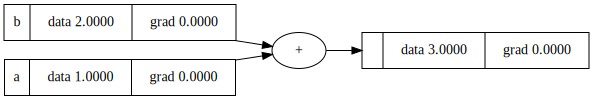

In [36]:
draw_dot(d)

In [37]:
e = d * c; e

Tensor(-12.0)

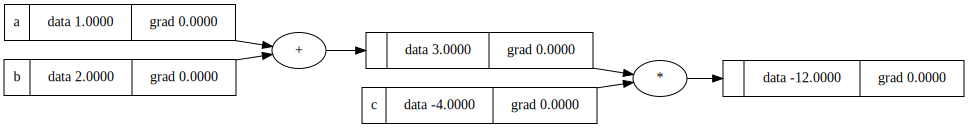

In [38]:
draw_dot(e)

In [39]:
d.backward(); d.grad

1.0

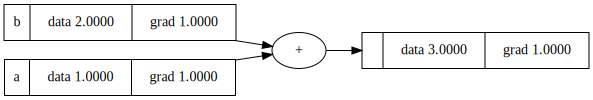

In [40]:
draw_dot(d)

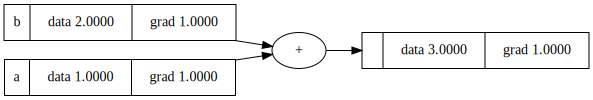

In [46]:
d.grad = 1.0
d._backward(); draw_dot(d)

In [47]:
e.backward(); e.grad

1.0

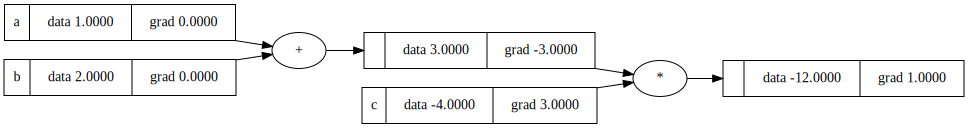

In [48]:
draw_dot(e)

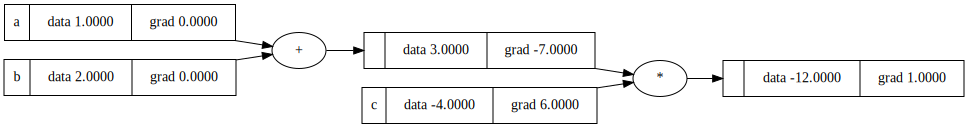

In [49]:
e.grad = 1.0
e._backward(); draw_dot(e)

In [50]:
a.tanh().data

0.7615941559557649

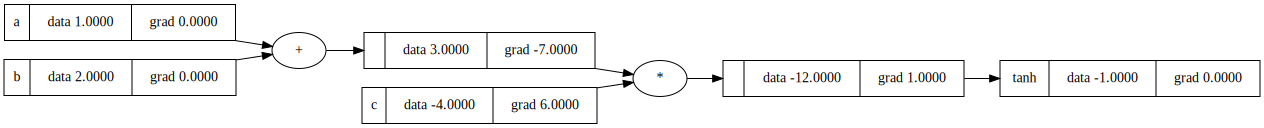

In [51]:
f = e.tanh(); draw_dot(f)

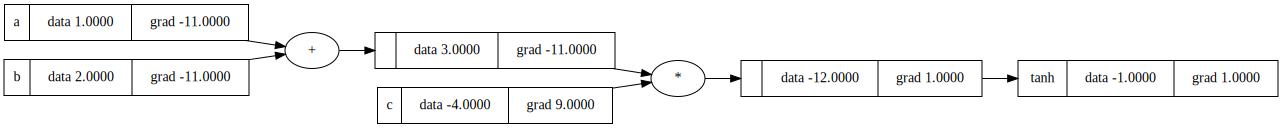

In [52]:
f.backward(); draw_dot(f)

In [53]:
a.tanh().grad

0.0

In [54]:
import torch
at = torch.Tensor([1.0])
bt = torch.Tensor([2.0])
ct = torch.Tensor([-4.0])

In [55]:
at.tanh().data[0]

tensor(0.7616)

In [56]:
at.tanh(); at.requires_grad = True

In [57]:
torch.isclose(at.tanh(), torch.Tensor([a.tanh().data]))

tensor([True])

In [58]:
import random
random.random() * 10

8.330348378296794

In [94]:
x1 = Tensor(0.0, label='x1')
x2 = Tensor(2.0, label='x1')

w1 = Tensor(1.0, label='w1')
w2 = Tensor(-2.0, label='w2')

b = Tensor(4.942069420, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

In [95]:
np.tanh(n)

Tensor(0.7361715985212502)

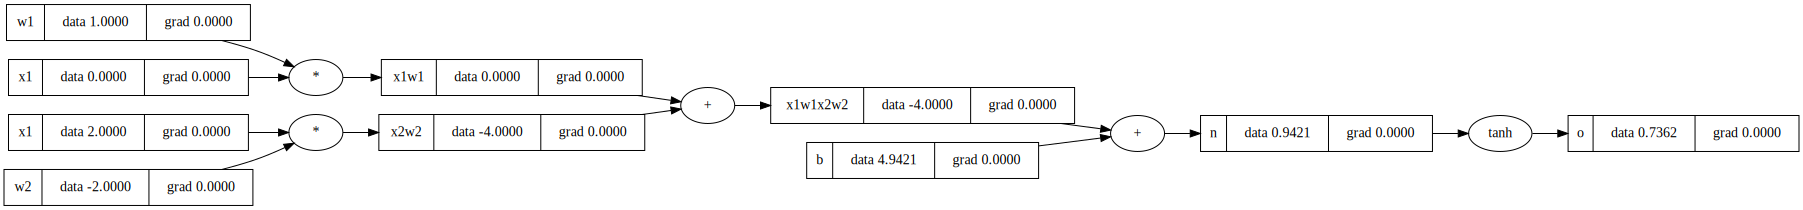

In [96]:
draw_dot(o)

In [97]:
o.backward()

In [98]:
o

Tensor(0.7361715985212502)

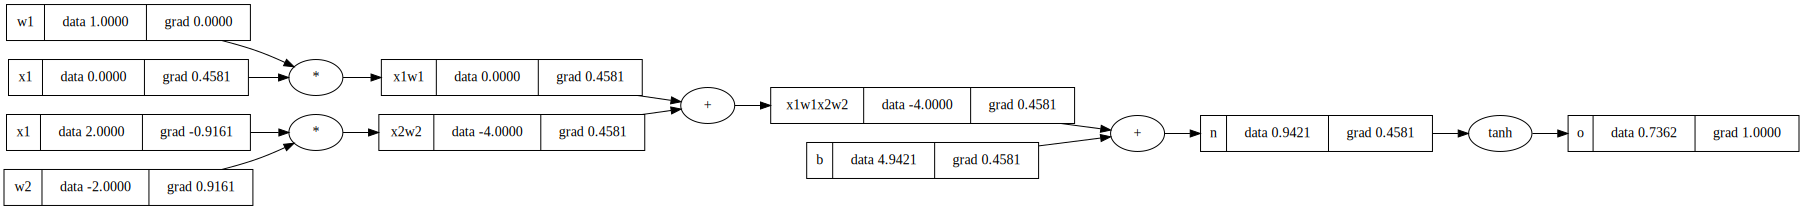

In [99]:
draw_dot(o)

In [102]:
x1 = Tensor(0.0, label='x1')
x2 = Tensor(2.0, label='x1')

w1 = Tensor(1.0, label='w1')
w2 = Tensor(-2.0, label='w2')

b = Tensor(4.942069420, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

## $tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{1 - e^{-2x}}{1 + e^{2x}}$

In [117]:
(e - 1) / (e + 1)

Tensor(0.7361715985212502)

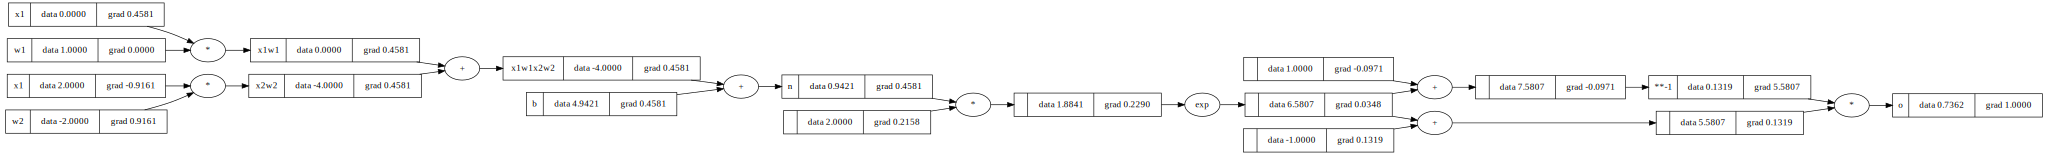

In [121]:
x1 = Tensor(0.0, label='x1')
x2 = Tensor(2.0, label='x1')

w1 = Tensor(1.0, label='w1')
w2 = Tensor(-2.0, label='w2')

b = Tensor(4.942069420, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

n = x1w1x2w2 + b; n.label='n'
e = (2*n).exp()
o = (e-1) / (e+1); o.label = 'o'
o.backward()
draw_dot(o)

In [1]:
from tensor import Tensor

In [2]:
x1 = Tensor(0.0)
x2 = Tensor(2.0)

w1 = Tensor(1.0)
w2 = Tensor(-2.0)

b = Tensor(4.942069420)

x1w1 = x1*w1
x2w2 = x2*w2
x1w1x2w2 = x1w1 + x2w2

n = x1w1x2w2 + b
e = (2*n).exp()
o = (e-1) / (e+1)

In [3]:
print(f"{x1=}")
print(f"{x2=}")
print(f"{w1=}")
print(f"{w2=}")
print(f"{b=}")
print(f"{x1w1=}")
print(f"{x2w2=}")
print(f"{x1w1x2w2=}")
print(f"{n=}")
print(f"{e=}")
print(f"{o=}")

x1=Tensor(data=0.0, grad=0.0)
x2=Tensor(data=2.0, grad=0.0)
w1=Tensor(data=1.0, grad=0.0)
w2=Tensor(data=-2.0, grad=0.0)
b=Tensor(data=4.94206942, grad=0.0)
x1w1=Tensor(data=0.0, grad=0.0)
x2w2=Tensor(data=-4.0, grad=0.0)
x1w1x2w2=Tensor(data=-4.0, grad=0.0)
n=Tensor(data=0.9420694200000002, grad=0.0)
e=Tensor(data=6.5806849785317425, grad=0.0)
o=Tensor(data=0.7361715985212502, grad=0.0)


In [4]:
o.backward()

In [5]:
print(f"{x1=}")
print(f"{x2=}")
print(f"{w1=}")
print(f"{w2=}")
print(f"{b=}")
print(f"{x1w1=}")
print(f"{x2w2=}")
print(f"{x1w1x2w2=}")
print(f"{n=}")
print(f"{e=}")
print(f"{o=}")

x1=Tensor(data=0.0, grad=0.0)
x2=Tensor(data=2.0, grad=0.0)
w1=Tensor(data=1.0, grad=0.0)
w2=Tensor(data=-2.0, grad=0.0)
b=Tensor(data=4.94206942, grad=0.0)
x1w1=Tensor(data=0.0, grad=0.0)
x2w2=Tensor(data=-4.0, grad=0.0)
x1w1x2w2=Tensor(data=-4.0, grad=0.0)
n=Tensor(data=0.9420694200000002, grad=0.0)
e=Tensor(data=6.5806849785317425, grad=-0.09711148802595869)
o=Tensor(data=0.7361715985212502, grad=1.0)
